In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt

import cv2

from torchvision import models
import torchvision.transforms as transforms
from PIL import Image

In [2]:
#initialize Sift and helpper functions

#Sift parameters
featureCount = 50
patchSize = 8
pad = patchSize//2

sift = cv2.xfeatures2d.SIFT_create(nfeatures = featureCount, contrastThreshold = 0.04, edgeThreshold = 25);

# structure: [x,y,size,angle, PpatchSizexPatchSize patch around x,y if possible]
def buildFeatureArray(keypoints):
    features = np.zeros([featureCount,2+1+1+(patchSize**2)*3])
    for i, kp in enumerate(keypoints):
        #apparently there are more than max-keypoints in keypoints. deiscord others
        if(i>=featureCount): continue;
        
        x = kp.pt[1]
        y = kp.pt[0]
        features[i,0:4] = [y, x, kp.size, kp.angle]
        patch = image[int(x)-pad:int(x)+pad, int(y)-pad:int(y)+pad]
        if(patch.size==3*patchSize**2):
            patch = patch.reshape(1,(patchSize**2)*3)
            features[i,4:] = patch
        else:
            print('Patch could not be extracted properly, values left 0 for patch')

    return features


# CUB_200_2011 Dataset

## Loading Data

In [3]:
filenames = open('CUB_200_2011/images.txt');
CUBImageNames = filenames.read().split()[1::2];
filenames.close();

#get (part_id,y,x) for visible parts, for a CUB image number 1 to 11788
def getCubParts(imageNr):
    
    if(imageNr <= 0 | imageNr > 11788):
        raise ValueError("imageNr requested must lie between 1 and 11788");
        return -1;
    
    partfile = open('CUB_200_2011/parts/part_locs.txt');
    allParts = partfile.readlines()
    partfile.close();
    
    offset = (imageNr-1)*15
    
    imageParts = allParts[offset:offset+15];
    result = np.zeros([15,3])
    zeroCount = 0;
    for i, line in enumerate(imageParts):
        elements = line.strip('\n').split()[1:5]
        if(elements[3] == '0'): 
            zeroCount+=1;
            continue;
        else: 
            result[i] = elements[0:3];
    
    result = result[np.nonzero(result)].reshape(len(result)//3-3*zeroCount,3)       
    
    return result

# get a CUB image given a number from 1 to 11788
def getImage(imageNr):
    
    if(imageNr <= 0 | imageNr > 11788):
        raise ValueError("imageNr requested must lie between 1 and 11788");
        return -1;
    
    return Image.open('CUB_200_2011/images/'+CUBImageNames[imageNr-1]);

def saveCubFeature(imageNr, featureArray):
    np.save('SiftFeatures/CUB/image_'+str(imageNr), featureArray)

def loadCubFeature(imageNr):
    return np.load('SiftFeatures/CUB/image_'+str(imageNr)+'.npy')

plotColors = np.array(['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                       '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabebe', 
                       '#469990', '#e6beff', '#9A6324', '#fffac8', '#800000'])

[[  2. 312. 182.]
 [  5. 186.  45.]
 [  6. 247.  79.]
 [ 10. 100. 221.]
 [ 11. 183. 101.]
 [ 15. 215. 194.]]


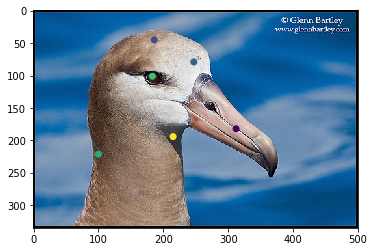

In [5]:
#show feature points
i = 1
image = getImage(i);
parts = getParts(i);
print(parts)
plt.scatter(parts[:,1],parts[:,2], c=parts[:,0])
plt.imshow(image)

## SIFT feature building

In [6]:
#adjust loop range to build entire database of features varying i=1 to 11788
for i in range(0, 10):
    image = cv2.imread('CUB_200_2011/images/'+CUBImageNames[i])
    keypoints = sift.detect(image,None)
    keyImage = cv2.drawKeypoints(image,keypoints,None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS);

    features = buildFeatureArray(keypoints);
        
    saveCubFeature(i, features);

Patch could not be extracted properly, values left 0 at image: 1
Patch could not be extracted properly, values left 0 at image: 1
Patch could not be extracted properly, values left 0 at image: 1
Patch could not be extracted properly, values left 0 at image: 1


In [7]:
#load features from a given image by specifying the image number to load from
F0 = loadCubFeature(1)

## VGG-16 feature building

In [8]:
#VGG in Torchvision requires a Torch Tensor of size 224*224 with value range of [0,1] as input. apply this function to do so.
def prepareImage(image):
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)) #arbitray values

    ])
    iTensor = transformation(image).float() #apply necessary transformations to fit into vgg16
    inputImage = iTensor.unsqueeze_(0) #make it a batch, as torchvision requires batches as inputs
    return inputImage

#outputs will hold intermediate features from the vgg-16 network wherever the hook(s) are attached to.
outputs = []
def hook(model, input, output):
    outputs.append(output)

# Download pretrained VGG-16 cnn and set it to evaluation mode to compute feature values of specific layers
vgg16 = models.vgg16(pretrained=True)
vgg16.eval();


In [2]:
#add hooks to the network to extract their features everytime a forward pass is run.
relu5_1_hook = vgg16.features[25].register_forward_hook(hook)
#relu5_1_hook.remove()
relu4_1_hook = vgg16.features[19].register_forward_hook(hook)
#relu4_1_hook.remove()

#alternative to extract features from a layer:
#relu5_1_features = vgg16.features[:26](inputImage)[0]

image = prepareImage(getImage(1))
parts = getParts(1)

#forward pass through vgg16
vgg16(image);

NameError: name 'vgg16' is not defined

In [10]:
relu5 = outputs[1][0]
relu4 = outputs[0][0]

In [11]:
relu5.shape

torch.Size([512, 14, 14])

In [12]:
#What now?

# Middlebury Dataset

## Loading Data 

In [18]:
#get an image by stating the folderNr, and the frame you want (either 0 or 1)
def loadMbImage(folderName, imageNr=0):
    content = os.listdir("Middlebury/other-color-twoframes/"+folderName);
    return cv2.imread("Middlebury/other-color-twoframes/"+folderName+'/'+content[imageNr])

def saveMbFeature(foldername, imageNr, featureArray):
    np.save('SiftFeatures/Middlebury/'+foldername+'_image_'+str(imageNr), featureArray)

def loadMbFeature(foldername, imageNr):
    return np.load('SiftFeatures/Middlebury/'+foldername+'_image_'+str(imageNr)+'.npy')

In [19]:
MiddleburyFolderNames

['Beanbags',
 'Dimetrodon',
 'DogDance',
 'Grove2',
 'Grove3',
 'Hydrangea',
 'MiniCooper',
 'RubberWhale',
 'Urban2',
 'Urban3',
 'Venus',
 'Walking']

In [20]:
#Testing the image loading
image = loadMbImage('Dimetrodon',0)

#show image in separate window
#cv2.imshow('image1',image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

## sift features 

In [21]:
#loop here to build entire database of features varying i=1 to 11788
for folder in MiddleburyFolderNames:
    for i in range(0,2):
        image = loadMbImage(folder,i)
        keypoints = sift.detect(image,None)
        keyImage = cv2.drawKeypoints(image,keypoints,None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS);

        features = buildFeatureArray(keypoints);
        
        #storing features:
        saveMbFeature(folder, i, features);

In [ ]:
#loading features:
f = loadMbFeature('Dimetrodon', 0)

## VGG features

In [22]:
#same as with CUB...

# Sintel Dataset 

## loading Data

In [23]:
sceneNames = os.listdir("MPI-Sintel-complete/training/final/");

def loadSintelImage(folderName, frameNr=0):
    content = os.listdir("MPI-Sintel-complete/training/final/"+folderName);
    return cv2.imread("MPI-Sintel-complete/training/final/"+folderName+'/'+content[frameNr])

def saveSintelFeature(foldername, imageNr, featureArray):
    np.save('SiftFeatures/Sintel/'+foldername+'_image_'+str(imageNr), featureArray)

def loadSintelFeature(foldername, imageNr):
    return np.load('SiftFeatures/Middlebury/'+foldername+'_image_'+str(imageNr)+'.npy')

In [24]:
sceneNames

['alley_1',
 'alley_2',
 'ambush_2',
 'ambush_4',
 'ambush_5',
 'ambush_6',
 'ambush_7',
 'bamboo_1',
 'bamboo_2',
 'bandage_1',
 'bandage_2',
 'cave_2',
 'cave_4',
 'market_2',
 'market_5',
 'market_6',
 'mountain_1',
 'shaman_2',
 'shaman_3',
 'sleeping_1',
 'sleeping_2',
 'temple_2',
 'temple_3']

## SIFT Features

In [25]:
#loop here to build entire database of features varying i=1 to 11788
for scene in sceneNames:
    for frame in range(0,2):
        image = loadSintelImage(scene, frame)
        keypoints = sift.detect(image,None)
        keyImage = cv2.drawKeypoints(image,keypoints,None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS);

        features = buildFeatureArray(keypoints);
        
        #save feature array
        saveSintelFeature(scene, frame, features)

In [27]:
#load frame features
#loadSintelFeature('alley_1', 0)

#Show image in separate window
#cv2.imshow('image1',keyImage)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

## VGG features

In [ ]:
#same as cub